<a href="https://colab.research.google.com/github/ge96lip/SPID-in-Molecular-Graphs/blob/main/Data_exploration_and_GNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load data and data exploation

In [2]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# Helper function for visualization.
%matplotlib inline
import matplotlib.pyplot as plt

2.6.0+cu124
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 72.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 78.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 7.7 MB/s eta 0:00:00


In [3]:
import torch
from torch_geometric.datasets import TUDataset

dataset = TUDataset(root='data/TUDataset', name='DHFR') # default data: MUTAG

Processing...
Done!


In [3]:
print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of node features: {dataset.num_node_features}')
print(f'Number of edge features: {dataset.num_edge_features}')
print(f'Number of classes: {dataset.num_classes}')
# average number of nodes
total_num_nodes = 0
for data in dataset:
    total_num_nodes += data.num_nodes
print(f'Average number of nodes: {total_num_nodes / len(dataset)}')

# average numbe of edges
total_num_edges = 0
for data in dataset:
    total_num_edges += data.num_edges
print(f'Average number of edges: {total_num_edges / len(dataset)}')

print()
print('Some statics for the first graph')
print('====================')
data = dataset[0]  # Get the first graph object.
print(data)
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: DHFR(756):
Number of graphs: 756
Number of features: 53
Number of node features: 53
Number of edge features: 0
Number of classes: 2
Average number of nodes: 42.42724867724868
Average number of edges: 89.08994708994709

Some statics for the first graph
Data(edge_index=[2, 62], x=[30, 53], y=[1])
Number of nodes: 30
Number of edges: 62
Average node degree: 2.07
Has isolated nodes: False
Has self-loops: False
Is undirected: True


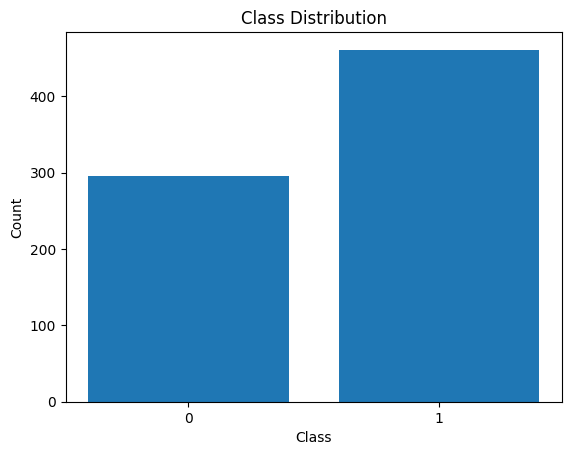

[295, 461]

In [3]:
def class_imbalance(dataset):
  y = [0] * dataset.num_classes
  for i in range(len(dataset)):
    y[dataset[i].y] += 1

  plt.bar((1,2), y)
  plt.xlabel('Class')
  plt.ylabel('Count')
  plt.xticks((1,2), ('0', '1'))
  plt.title('Class Distribution')
  plt.show()
  return y

class_imbalance(dataset)


## GNNs

In [4]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)

        return x

model = GCN(hidden_channels=64)
print(model)

GCN(
  (conv1): GCNConv(53, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)


In [5]:
from torch_geometric.nn import GraphConv
from torch.nn import BatchNorm1d
from torch_geometric.nn import global_mean_pool, global_max_pool, global_add_pool

class GNN(torch.nn.Module):
    def __init__(self, hidden_channels, pooling='mean'):
        super(GNN, self).__init__()
        torch.manual_seed(42)

        self.conv1 = GraphConv(dataset.num_node_features, hidden_channels)
        self.bn1 = BatchNorm1d(hidden_channels)

        self.conv2 = GraphConv(hidden_channels, hidden_channels)
        self.bn2 = BatchNorm1d(hidden_channels)

        self.conv3 = GraphConv(hidden_channels, hidden_channels)
        self.bn3 = BatchNorm1d(hidden_channels)

        self.lin = Linear(hidden_channels, dataset.num_classes)

        # Choose pooling method
        if pooling == 'mean':
            self.pool = global_mean_pool
        elif pooling == 'max':
            self.pool = global_max_pool
        elif pooling == 'add':
            self.pool = global_add_pool
        else:
            raise ValueError("pooling must be 'mean', 'max', or 'add'")

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x, inplace=True)

        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.relu(x, inplace=True)

        x = self.conv3(x, edge_index)
        x = self.bn3(x)

        x = self.pool(x, batch)  # graph-level pooling

        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)

        return x

model = GNN(hidden_channels=64)
print(model)

GNN(
  (conv1): GraphConv(53, 64)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): GraphConv(64, 64)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): GraphConv(64, 64)
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)


### split data and create baches (NOT FOR cross validation)

Train size: 604
Test size: 152
<class 'torch_geometric.datasets.tu_dataset.TUDataset'>
Number of training graphs: 604
Number of test graphs: 152
<class 'torch_geometric.datasets.tu_dataset.TUDataset'>
<class 'torch_geometric.datasets.tu_dataset.TUDataset'>


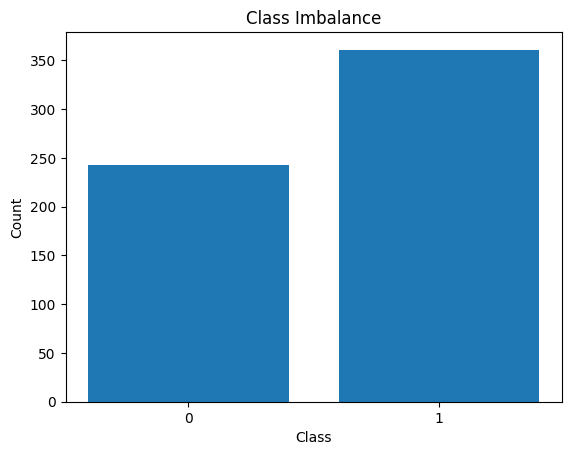

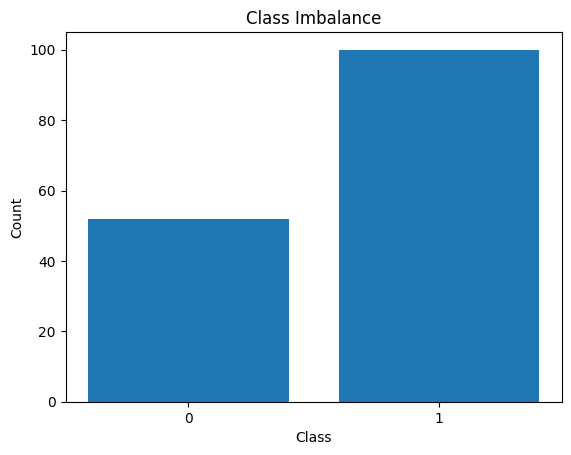

[52, 100]

In [ ]:
import random

# Set seed for reproducibility
random.seed(42)

# Total dataset size
num_samples = len(dataset)

# Generate and shuffle indices
indices = list(range(num_samples))
random.shuffle(indices)

# 80/20 split
split_point = int(0.8 * num_samples)
train_indices = indices[:split_point]
test_indices = indices[split_point:]

train_dataset = dataset[train_indices]
test_dataset = dataset[test_indices]

# Optional: verify
print(f"Train size: {len(train_dataset)}")
print(f"Test size: {len(test_dataset)}")
print(type(train_dataset))  # <class 'list'>

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')
print(type(dataset))
print(type(train_dataset))
class_imbalance(train_dataset)
class_imbalance(test_dataset)


In [ ]:
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

Step 1:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 5484], x=[2619, 53], y=[64], batch=[2619], ptr=[65])

Step 2:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 5618], x=[2666, 53], y=[64], batch=[2666], ptr=[65])

Step 3:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 5864], x=[2793, 53], y=[64], batch=[2793], ptr=[65])

Step 4:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 5888], x=[2799, 53], y=[64], batch=[2799], ptr=[65])

Step 5:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 5524], x=[2632, 53], y=[64], batch=[2632], ptr=[65])

Step 6:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 5836], x=[2782, 53], y=[64], batch=[2782], ptr=[65])

Step 7:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 5886], x=[2801, 53], y=[64], batch=[2801], ptr=[65])

Step 8:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 5506], x=[2628, 53], y

In [ ]:
def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
         out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
         loss = criterion(out, data.y)  # Compute the loss.
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.

def test(loader):
     model.eval()

     correct = 0
     for data in loader:  # Iterate in batches over the training/test dataset.
         out = model(data.x, data.edge_index, data.batch)
         pred = out.argmax(dim=1)  # Use the class with highest probability.
         correct += int((pred == data.y).sum())  # Check against ground-truth labels.
     return correct / len(loader.dataset)  # Derive ratio of correct predictions.

In [ ]:
# TRAIN GCN
model = GCN(hidden_channels=64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

for epoch in range(1, 51):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

In [ ]:
# Train GNN
model = GNN(hidden_channels=64)
print(model)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for epoch in range(1, 51):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

### k-fold cross validation

Using device: cuda

=== Training GNN Across 10 Folds ===


Fold 1/10
Epoch 001, Train Loss: 0.6863, Val Loss: 0.7807, Val Acc: 0.4079
Epoch 002, Train Loss: 0.6747, Val Loss: 0.7640, Val Acc: 0.4079
Epoch 003, Train Loss: 0.6655, Val Loss: 0.7281, Val Acc: 0.4079
Epoch 004, Train Loss: 0.6518, Val Loss: 0.6869, Val Acc: 0.5921
Epoch 005, Train Loss: 0.6549, Val Loss: 0.6508, Val Acc: 0.6579
Epoch 006, Train Loss: 0.6454, Val Loss: 0.6307, Val Acc: 0.6974
Epoch 007, Train Loss: 0.6394, Val Loss: 0.6207, Val Acc: 0.6974
Epoch 008, Train Loss: 0.6336, Val Loss: 0.6124, Val Acc: 0.7105
Epoch 009, Train Loss: 0.6266, Val Loss: 0.6072, Val Acc: 0.7105
Epoch 010, Train Loss: 0.6182, Val Loss: 0.6014, Val Acc: 0.7237
Epoch 011, Train Loss: 0.6105, Val Loss: 0.5969, Val Acc: 0.7368
Epoch 012, Train Loss: 0.6119, Val Loss: 0.5875, Val Acc: 0.7237
Epoch 013, Train Loss: 0.6034, Val Loss: 0.5846, Val Acc: 0.7105
Epoch 014, Train Loss: 0.6057, Val Loss: 0.5794, Val Acc: 0.7105
Epoch 015, Train Loss

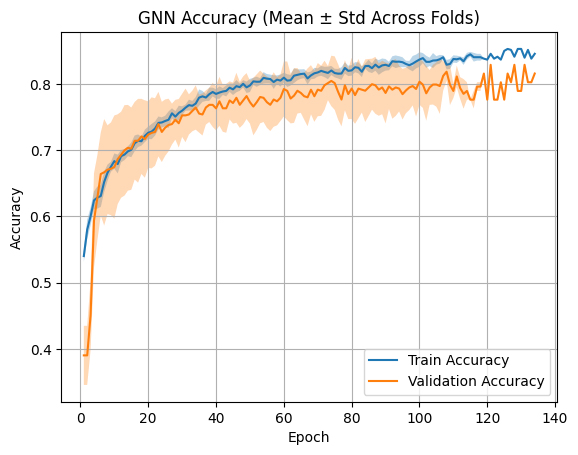

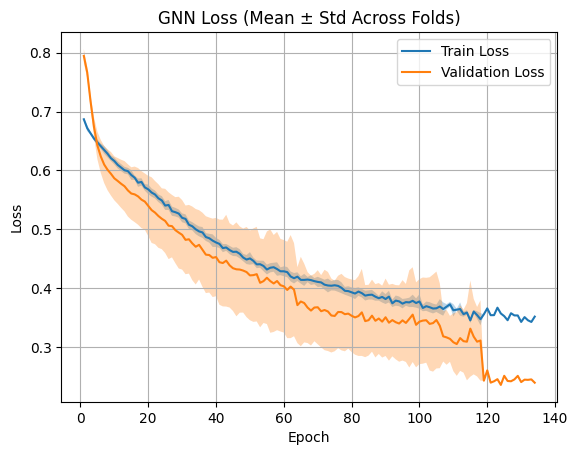

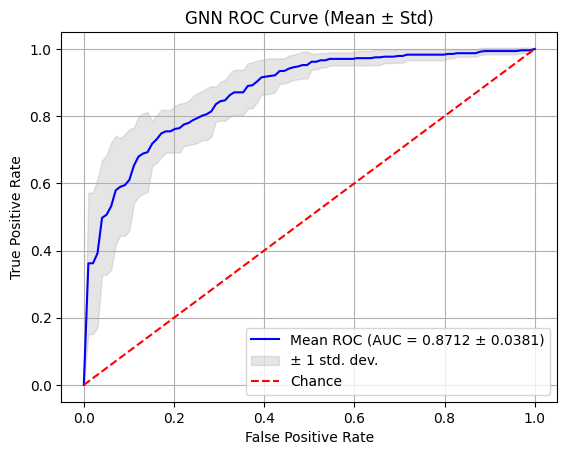


=== Final Results ===
GCN Mean Accuracy: nan ± nan
GNN Mean Accuracy: 0.7871 ± 0.0401


/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:218: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:175: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:210: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [6]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch_geometric.loader import DataLoader
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, auc, classification_report

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# K-Fold setup
k_folds = 10
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# Store final fold results
gcn_fold_acc = []
gnn_fold_acc = []

for model_type in ['GNN']:
    print(f'\n=== Training {model_type} Across {k_folds} Folds ===\n')

    fold_accuracies = []
    all_train_acc, all_val_acc, all_train_loss, all_val_loss = [], [], [], []

    fpr_list = []
    tpr_list = []
    auc_list = []

    for fold, (train_idx, test_idx) in enumerate(kf.split(dataset)):
        print(f'\nFold {fold + 1}/{k_folds}')

        # Split data
        train_dataset = dataset[train_idx.tolist()]
        test_dataset = dataset[test_idx.tolist()]
        train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

        # Initialize model
        model = GCN(hidden_channels=64) if model_type == 'GCN' else GNN(hidden_channels=64)
        model = model.to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=5e-4)
        criterion = torch.nn.CrossEntropyLoss()

        # Logs
        train_accuracies, val_accuracies = [], []
        train_losses, val_losses = [], []

        # Define steps
        def train_step(loader):
            model.train()
            total_loss, correct = 0, 0
            for data in loader:
                data = data.to(device)
                optimizer.zero_grad()
                out = model(data.x, data.edge_index, data.batch)
                loss = criterion(out, data.y)
                loss.backward()
                optimizer.step()

                total_loss += loss.item()
                pred = out.argmax(dim=1)
                correct += int((pred == data.y).sum())

            return total_loss / len(loader), correct / len(loader.dataset)

        def evaluate(loader, return_preds=False):
            model.eval()
            total_loss, correct = 0, 0
            y_true, y_pred, y_score = [], [], []
            for data in loader:
                data = data.to(device)
                with torch.no_grad():
                    out = model(data.x, data.edge_index, data.batch)
                    loss = criterion(out, data.y)
                    total_loss += loss.item()

                    probs = F.softmax(out, dim=1)
                    pred = probs.argmax(dim=1)
                    correct += int((pred == data.y).sum())

                    y_true += data.y.tolist()
                    y_pred += pred.tolist()
                    y_score += probs[:,1].tolist()  # Probability for positive class

            if return_preds:
                return total_loss / len(loader), correct / len(loader.dataset), y_true, y_pred, y_score
            else:
                return total_loss / len(loader), correct / len(loader.dataset)

        # Early Stopping Setup
        patience = 10
        best_val_loss = float('inf')
        epochs_without_improvement = 0
        best_model_state = None

        # Train loop
        for epoch in range(1, 201):
            train_loss, train_acc = train_step(train_loader)
            val_loss, val_acc = evaluate(test_loader)

            train_losses.append(train_loss)
            val_losses.append(val_loss)
            train_accuracies.append(train_acc)
            val_accuracies.append(val_acc)

            print(f'Epoch {epoch:03d}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                epochs_without_improvement = 0
                best_model_state = model.state_dict()
            else:
                epochs_without_improvement += 1

            if epochs_without_improvement >= patience:
                print(f'--> Early stopping at epoch {epoch}')
                break

        # Load best model
        model.load_state_dict(best_model_state)

        # Final evaluation
        _, final_acc, y_true, y_pred, y_score = evaluate(test_loader, return_preds=True)
        fold_accuracies.append(final_acc)

        # ROC Curve
        fpr, tpr, _ = roc_curve(y_true, y_score)
        roc_auc = auc(fpr, tpr)
        fpr_list.append(fpr)
        tpr_list.append(tpr)
        auc_list.append(roc_auc)

        print(f'{model_type} - Fold {fold+1} Final Accuracy: {final_acc:.4f}')
        print(classification_report(y_true, y_pred, digits=4))

        # Save logs
        all_train_acc.append(train_accuracies)
        all_val_acc.append(val_accuracies)
        all_train_loss.append(train_losses)
        all_val_loss.append(val_losses)

    # Final fold performance
    if model_type == 'GCN':
        gcn_fold_acc = fold_accuracies
    else:
        gnn_fold_acc = fold_accuracies

    # === Padding for Early Stopping Different Lengths ===
    max_len = max(len(l) for l in all_train_loss)

    def pad_with_nan(arr, target_len):
        return np.concatenate([arr, np.full(target_len - len(arr), np.nan)])

    all_train_loss = [pad_with_nan(np.array(l), max_len) for l in all_train_loss]
    all_val_loss = [pad_with_nan(np.array(l), max_len) for l in all_val_loss]
    all_train_acc = [pad_with_nan(np.array(l), max_len) for l in all_train_acc]
    all_val_acc = [pad_with_nan(np.array(l), max_len) for l in all_val_acc]

    avg_train_loss = np.nanmean(all_train_loss, axis=0)
    std_train_loss = np.nanstd(all_train_loss, axis=0)
    avg_val_loss = np.nanmean(all_val_loss, axis=0)
    std_val_loss = np.nanstd(all_val_loss, axis=0)

    avg_train_acc = np.nanmean(all_train_acc, axis=0)
    std_train_acc = np.nanstd(all_train_acc, axis=0)
    avg_val_acc = np.nanmean(all_val_acc, axis=0)
    std_val_acc = np.nanstd(all_val_acc, axis=0)

    epochs = np.arange(1, len(avg_train_loss) + 1)

    # === Plot Accuracy ===
    plt.figure()
    plt.plot(epochs, avg_train_acc, label='Train Accuracy')
    plt.fill_between(epochs, avg_train_acc - std_train_acc, avg_train_acc + std_train_acc, alpha=0.3)

    plt.plot(epochs, avg_val_acc, label='Validation Accuracy')
    plt.fill_between(epochs, avg_val_acc - std_val_acc, avg_val_acc + std_val_acc, alpha=0.3)

    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'{model_type} Accuracy (Mean ± Std Across Folds)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # === Plot Loss ===
    plt.figure()
    plt.plot(epochs, avg_train_loss, label='Train Loss')
    plt.fill_between(epochs, avg_train_loss - std_train_loss, avg_train_loss + std_train_loss, alpha=0.3)

    plt.plot(epochs, avg_val_loss, label='Validation Loss')
    plt.fill_between(epochs, avg_val_loss - std_val_loss, avg_val_loss + std_val_loss, alpha=0.3)

    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{model_type} Loss (Mean ± Std Across Folds)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # === Plot ROC ===
    mean_fpr = np.linspace(0, 1, 100)
    tprs = []
    for i in range(len(fpr_list)):
        interp_tpr = np.interp(mean_fpr, fpr_list[i], tpr_list[i])
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)

    mean_tpr = np.mean(tprs, axis=0)
    std_tpr = np.std(tprs, axis=0)

    mean_auc = np.mean(auc_list)
    std_auc = np.std(auc_list)

    plt.figure()
    plt.plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC (AUC = {mean_auc:.4f} ± {std_auc:.4f})')
    plt.fill_between(mean_fpr, mean_tpr - std_tpr, mean_tpr + std_tpr, color='grey', alpha=0.2, label='± 1 std. dev.')
    plt.plot([0, 1], [0, 1], linestyle='--', color='r', label='Chance')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_type} ROC Curve (Mean ± Std)')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

# === Final results summary ===
print('\n=== Final Results ===')
print(f'GCN Mean Accuracy: {np.mean(gcn_fold_acc):.4f} ± {np.std(gcn_fold_acc):.4f}')
print(f'GNN Mean Accuracy: {np.mean(gnn_fold_acc):.4f} ± {np.std(gnn_fold_acc):.4f}')


In [6]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)


Using device: cuda



=== Training GNN Across 10 Folds ===


Fold 1/10
Epoch 010, Train Loss: 0.6182, Val Loss: 0.6014, Val Acc: 0.7237
Epoch 020, Train Loss: 0.5693, Val Loss: 0.5574, Val Acc: 0.7105
Epoch 030, Train Loss: 0.5182, Val Loss: 0.5231, Val Acc: 0.7500
Epoch 040, Train Loss: 0.4712, Val Loss: 0.4828, Val Acc: 0.8026
Epoch 050, Train Loss: 0.4348, Val Loss: 0.4458, Val Acc: 0.8026
Epoch 060, Train Loss: 0.4240, Val Loss: 0.4122, Val Acc: 0.8158
Epoch 070, Train Loss: 0.4074, Val Loss: 0.4268, Val Acc: 0.7763
Epoch 080, Train Loss: 0.3882, Val Loss: 0.3959, Val Acc: 0.8158
Epoch 090, Train Loss: 0.3783, Val Loss: 0.4041, Val Acc: 0.7763
Epoch 100, Train Loss: 0.3692, Val Loss: 0.3715, Val Acc: 0.7895
GNN - Fold 1 Final Accuracy: 0.7895
              precision    recall  f1-score   support

           0     0.7586    0.7097    0.7333        31
           1     0.8085    0.8444    0.8261        45

    accuracy                         0.7895        76
   macro avg     0.7836    0.7771    0.7797   

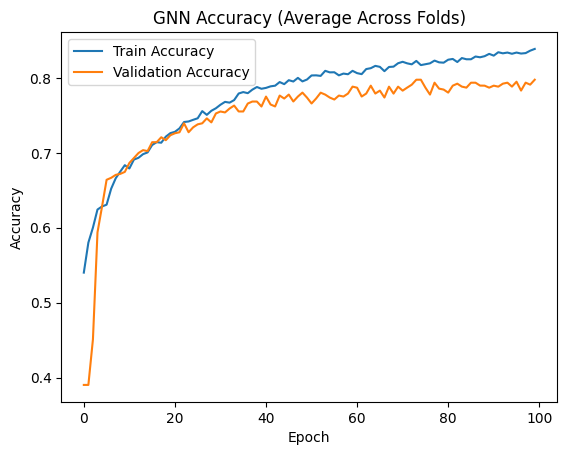

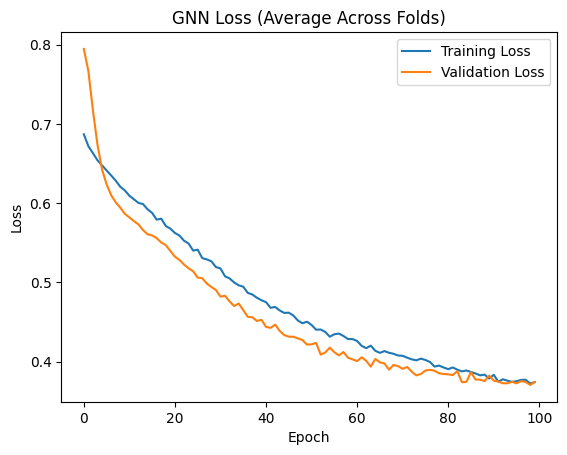


=== Final Results ===
GCN Mean Accuracy: nan ± nan
GNN Mean Accuracy: 0.7977 ± 0.0364


/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:218: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:175: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:210: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [17]:
from torch_geometric.loader import DataLoader
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

k_folds = 10
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

gcn_fold_acc = []
gnn_fold_acc = []

for model_type in ['GNN']:
    print(f'\n=== Training {model_type} Across {k_folds} Folds ===\n')

    fold_accuracies = []
    all_train_acc, all_val_acc, all_train_loss, all_val_loss = [], [], [], []

    for fold, (train_idx, test_idx) in enumerate(kf.split(dataset)):
        print(f'\nFold {fold + 1}/{k_folds}')

        train_dataset = dataset[train_idx.tolist()]
        test_dataset = dataset[test_idx.tolist()]
        train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

        model = GCN(hidden_channels=64) if model_type == 'GCN' else GNN(hidden_channels=64)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=5e-4)
        criterion = torch.nn.CrossEntropyLoss()

        model = model.to(device)

        # Logs
        train_accuracies = []
        val_accuracies = []
        train_losses = []
        val_losses = []

        # === Train Step and Evaluation Functions ===
        def train_step(loader):
            model.train()
            total_loss = 0
            correct = 0
            for data in loader:
                data = data.to(device)  # <--- move data batch to GPU
                optimizer.zero_grad()
                out = model(data.x, data.edge_index, data.batch)
                loss = criterion(out, data.y)
                loss.backward()
                optimizer.step()

                total_loss += loss.item()
                pred = out.argmax(dim=1)
                correct += int((pred == data.y).sum())

            avg_loss = total_loss / len(loader)
            acc = correct / len(loader.dataset)
            return avg_loss, acc

        def evaluate(loader, return_preds=False):
            model.eval()
            total_loss = 0
            correct = 0
            y_true, y_pred = [], []
            for data in loader:
                data = data.to(device)  # <--- move data batch to GPU
                with torch.no_grad():
                    out = model(data.x, data.edge_index, data.batch)
                    loss = criterion(out, data.y)
                    total_loss += loss.item()

                    pred = out.argmax(dim=1)
                    correct += int((pred == data.y).sum())
                    y_true += data.y.tolist()
                    y_pred += pred.tolist()

            avg_loss = total_loss / len(loader)
            acc = correct / len(loader.dataset)
            if return_preds:
                return avg_loss, acc, y_true, y_pred
            else:
                return avg_loss, acc

        # === Early Stopping Parameters ===
        patience = 10
        best_val_loss = float('inf')
        epochs_without_improvement = 0
        best_model_state = None

        # Training loop
        for epoch in range(1, 101):  # Allow more epochs now
            train_loss, train_acc = train_step(train_loader)
            val_loss, val_acc = evaluate(test_loader)

            train_losses.append(train_loss)
            val_losses.append(val_loss)
            train_accuracies.append(train_acc)
            val_accuracies.append(val_acc)

            if epoch % 10 == 0:
                print(f'Epoch {epoch:03d}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

            # Early Stopping Check
            """
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                epochs_without_improvement = 0
                best_model_state = model.state_dict()
            else:
                epochs_without_improvement += 1

            if epochs_without_improvement >= patience:
                print(f'--> Early stopping at epoch {epoch}')
                break
            """

        # Load best model
        #model.load_state_dict(best_model_state)

        # Final evaluation
        _, final_acc, y_true, y_pred = evaluate(test_loader, return_preds=True)
        fold_accuracies.append(final_acc)
        print(f'{model_type} - Fold {fold+1} Final Accuracy: {final_acc:.4f}')
        print(classification_report(y_true, y_pred, digits=4))

        # Store logs
        all_train_acc.append(train_accuracies)
        all_val_acc.append(val_accuracies)
        all_train_loss.append(train_losses)
        all_val_loss.append(val_losses)

    # Store model performance
    if model_type == 'GCN':
        gcn_fold_acc = fold_accuracies
    else:
        gnn_fold_acc = fold_accuracies

    # Plot average accuracy and loss across folds
    avg_train_acc = np.mean(all_train_acc, axis=0)
    avg_val_acc = np.mean(all_val_acc, axis=0)
    avg_train_loss = np.mean(all_train_loss, axis=0)
    avg_val_loss = np.mean(all_val_loss, axis=0)

    # Accuracy
    plt.figure()
    plt.plot(avg_train_acc, label='Train Accuracy')
    plt.plot(avg_val_acc, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'{model_type} Accuracy (Average Across Folds)')
    plt.legend()
    plt.show()

    # Loss
    plt.figure()
    plt.plot(avg_train_loss, label='Training Loss')
    plt.plot(avg_val_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{model_type} Loss (Average Across Folds)')
    plt.legend()
    plt.show()

# Final summary
print('\n=== Final Results ===')
print(f'GCN Mean Accuracy: {np.mean(gcn_fold_acc):.4f} ± {np.std(gcn_fold_acc):.4f}')
print(f'GNN Mean Accuracy: {np.mean(gnn_fold_acc):.4f} ± {np.std(gnn_fold_acc):.4f}')


In [18]:
import numpy as np

# Step 1: Pad all lists to the same length with np.nan
max_len = max(len(l) for l in all_train_loss)

def pad_with_nan(arr, target_len):
    return np.concatenate([arr, np.full(target_len - len(arr), np.nan)])

all_train_loss = [pad_with_nan(np.array(l), max_len) for l in all_train_loss]
all_val_loss = [pad_with_nan(np.array(l), max_len) for l in all_val_loss]
all_train_acc = [pad_with_nan(np.array(l), max_len) for l in all_train_acc]
all_val_acc = [pad_with_nan(np.array(l), max_len) for l in all_val_acc]

# Step 2: Now take nanmean/nanstd safely
avg_train_loss = np.nanmean(all_train_loss, axis=0)
std_train_loss = np.nanstd(all_train_loss, axis=0)
avg_val_loss = np.nanmean(all_val_loss, axis=0)
std_val_loss = np.nanstd(all_val_loss, axis=0)

avg_train_acc = np.nanmean(all_train_acc, axis=0)
std_train_acc = np.nanstd(all_train_acc, axis=0)
avg_val_acc = np.nanmean(all_val_acc, axis=0)
std_val_acc = np.nanstd(all_val_acc, axis=0)


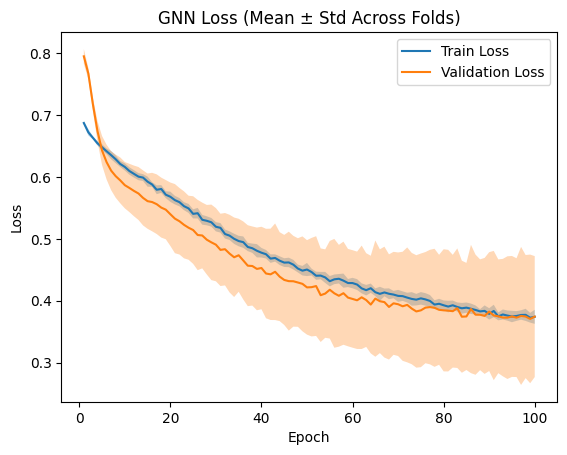

In [19]:
epochs = np.arange(1, len(avg_train_loss) + 1)

plt.figure()
plt.plot(epochs, avg_train_loss, label='Train Loss')
plt.fill_between(epochs, avg_train_loss - std_train_loss, avg_train_loss + std_train_loss, alpha=0.3)

plt.plot(epochs, avg_val_loss, label='Validation Loss')
plt.fill_between(epochs, avg_val_loss - std_val_loss, avg_val_loss + std_val_loss, alpha=0.3)

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'{model_type} Loss (Mean ± Std Across Folds)')
plt.legend()
plt.show()


In [1]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import torch

# Put model in evaluation mode
model.eval()
model.to(device)

embeddings = []
labels = []
pred_labels = []


# Use your full test_loader or dataset loader
for data in test_loader:
    data = data.to(device)
    with torch.no_grad():
        x = model.conv1(data.x, data.edge_index)
        x = model.bn1(x)
        x = F.relu(x)
        x = model.conv2(x, data.edge_index)
        x = model.bn2(x)
        x = F.relu(x)
        x = model.conv3(x, data.edge_index)
        x = model.bn3(x)

        # Use the same pooling function from your model
        x = model.pool(x, data.batch)
        embeddings.append(x)
        labels += data.y.tolist()

        # Predict class
        out = model.lin(F.dropout(x, p=0.5, training=False))
        pred = out.argmax(dim=1)
        pred_labels += pred.tolist()

# Combine embeddings
embeddings = torch.cat(embeddings, dim=0).cpu().numpy()

# Reduce to 2D using t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
proj = tsne.fit_transform(embeddings)

# Plotting
plt.figure(figsize=(8,6))
scatter = plt.scatter(proj[:, 0], proj[:, 1], c=labels, cmap='coolwarm', alpha=0.7)
plt.colorbar(scatter, label='True Class')
plt.title('t-SNE Visualization of Graph Embeddings')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.grid(True)
plt.show()

# Plot
plt.figure(figsize=(8,6))
scatter = plt.scatter(proj[:, 0], proj[:, 1], c=pred_labels, cmap='coolwarm', alpha=0.7)
plt.colorbar(scatter, label='Predicted Class')
plt.title('t-SNE of Graph Embeddings (Predicted Labels)')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.grid(True)
plt.show()



NameError: name 'model' is not defined

## interpretabillity (in progress)

# ----

In [ ]:
from torch_geometric.loader import DataLoader
from torch_geometric.datasets import TUDataset

path = '.'
dataset = TUDataset(path, name='DHFR').shuffle()
test_dataset = dataset[:len(dataset) // 10]
train_dataset = dataset[len(dataset) // 10:]
test_loader = DataLoader(test_dataset, batch_size=128)
train_loader = DataLoader(train_dataset, batch_size=128)

In [ ]:
print(dataset)

DHFR(756)


In [ ]:
import networkx as nx
import numpy as np

from torch_geometric.utils import to_networkx


def draw_molecule(g, edge_mask=None, draw_edge_labels=False):
    g = g.copy().to_undirected()
    node_labels = {}
    for u, data in g.nodes(data=True):
        node_labels[u] = data['name']
    pos = nx.planar_layout(g)
    pos = nx.spring_layout(g, pos=pos)
    if edge_mask is None:
        edge_color = 'black'
        widths = None
    else:
        edge_color = [edge_mask[(u, v)] for u, v in g.edges()]
        widths = [x * 10 for x in edge_color]
    nx.draw(g, pos=pos, labels=node_labels, width=widths,
            edge_color=edge_color, edge_cmap=plt.cm.Blues,
            node_color='azure')

    if draw_edge_labels and edge_mask is not None:
        edge_labels = {k: ('%.2f' % v) for k, v in edge_mask.items()}
        nx.draw_networkx_edge_labels(g, pos, edge_labels=edge_labels,
                                    font_color='red')
    plt.show()


def to_molecule(data):
    ATOM_MAP = ['C', 'O', 'Cl', 'H', 'N', 'F', 'Br', 'S', 'P', 'I', 'Na', 'K', 'Li', 'Ca'] \
         + [f'X{i}' for i in range(53 - 14)]  # fill remaining with placeholders

    g = to_networkx(data, node_attrs=['x'])
    for u, data in g.nodes(data=True):
        data['name'] = ATOM_MAP[data['x'].index(1.0)]
        del data['x']
    return g


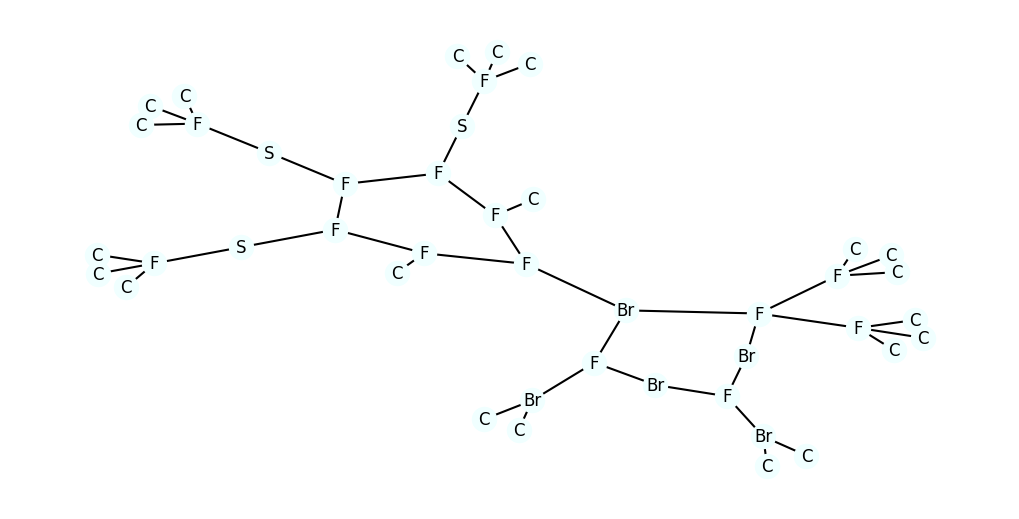

In [ ]:
import random

data = train_dataset[100]
mol = to_molecule(data)
plt.figure(figsize=(10, 5))
draw_molecule(mol)


In [ ]:
import torch
from torch.nn import Linear
import torch.nn.functional as F

from torch_geometric.nn import GraphConv, global_add_pool

class Net(torch.nn.Module):
    def __init__(self, dim):
        super(Net, self).__init__()

        num_features = dataset.num_features
        self.dim = dim

        self.conv1 = GraphConv(num_features, dim)
        self.conv2 = GraphConv(dim, dim)
        self.conv3 = GraphConv(dim, dim)
        self.conv4 = GraphConv(dim, dim)
        self.conv5 = GraphConv(dim, dim)

        self.lin1 = Linear(dim, dim)
        self.lin2 = Linear(dim, dataset.num_classes)

    def forward(self, x, edge_index, batch, edge_weight=None):
        x = self.conv1(x, edge_index, edge_weight).relu()
        x = self.conv2(x, edge_index, edge_weight).relu()
        x = self.conv3(x, edge_index, edge_weight).relu()
        x = self.conv4(x, edge_index, edge_weight).relu()
        x = self.conv5(x, edge_index, edge_weight).relu()
        x = global_add_pool(x, batch)
        x = self.lin1(x).relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return F.log_softmax(x, dim=-1)


In [ ]:
def train(epoch):
    model.train()

    if epoch == 51:
        for param_group in optimizer.param_groups:
            param_group['lr'] = 0.5 * param_group['lr']

    loss_all = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data.x, data.edge_index, data.batch)
        loss = F.nll_loss(output, data.y)
        loss.backward()
        loss_all += loss.item() * data.num_graphs
        optimizer.step()
    return loss_all / len(train_dataset)


def test(loader):
    model.eval()

    correct = 0
    for data in loader:
        data = data.to(device)
        output = model(data.x, data.edge_index, data.batch)
        pred = output.max(dim=1)[1]
        correct += pred.eq(data.y).sum().item()
    return correct / len(loader.dataset)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net(dim=32).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(1, 50):
    loss = train(epoch)
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, '
          f'Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')


Epoch: 001, Loss: 0.9622, Train Acc: 0.6079, Test Acc: 0.6267
Epoch: 002, Loss: 0.6890, Train Acc: 0.6021, Test Acc: 0.6400
Epoch: 003, Loss: 0.6950, Train Acc: 0.5301, Test Acc: 0.5733
Epoch: 004, Loss: 0.6941, Train Acc: 0.5991, Test Acc: 0.6267
Epoch: 005, Loss: 0.6874, Train Acc: 0.6079, Test Acc: 0.6267
Epoch: 006, Loss: 0.6880, Train Acc: 0.6079, Test Acc: 0.6267
Epoch: 007, Loss: 0.6932, Train Acc: 0.6079, Test Acc: 0.6267
Epoch: 008, Loss: 0.6841, Train Acc: 0.6079, Test Acc: 0.6267
Epoch: 009, Loss: 0.6814, Train Acc: 0.6079, Test Acc: 0.6267
Epoch: 010, Loss: 0.6819, Train Acc: 0.6079, Test Acc: 0.6267
Epoch: 011, Loss: 0.6789, Train Acc: 0.6079, Test Acc: 0.6267
Epoch: 012, Loss: 0.6707, Train Acc: 0.6079, Test Acc: 0.6267
Epoch: 013, Loss: 0.6740, Train Acc: 0.6094, Test Acc: 0.5067
Epoch: 014, Loss: 0.6678, Train Acc: 0.6079, Test Acc: 0.6267
Epoch: 015, Loss: 0.6577, Train Acc: 0.6079, Test Acc: 0.6267
Epoch: 016, Loss: 0.6456, Train Acc: 0.6446, Test Acc: 0.5733
Epoch: 0

In [ ]:
!pip install -q captum

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 48.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 94.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 77.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21

In [ ]:
from captum.attr import Saliency, IntegratedGradients

def model_forward(edge_mask, data):
    batch = torch.zeros(data.x.shape[0], dtype=int).to(device)
    out = model(data.x, data.edge_index, batch, edge_mask)
    return out


def explain(method, data, target=0):
    input_mask = torch.ones(data.edge_index.shape[1]).requires_grad_(True).to(device)
    if method == 'ig':
        ig = IntegratedGradients(model_forward)
        mask = ig.attribute(input_mask, target=target,
                            additional_forward_args=(data,),
                            internal_batch_size=data.edge_index.shape[1])
    elif method == 'saliency':
        saliency = Saliency(model_forward)
        mask = saliency.attribute(input_mask, target=target,
                                  additional_forward_args=(data,))
    else:
        raise Exception('Unknown explanation method')

    edge_mask = np.abs(mask.cpu().detach().numpy())
    if edge_mask.max() > 0:  # avoid division by zero
        edge_mask = edge_mask / edge_mask.max()
    return edge_mask

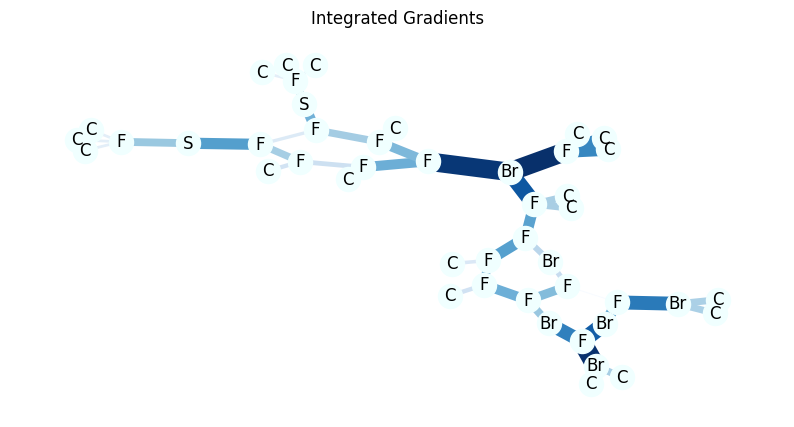

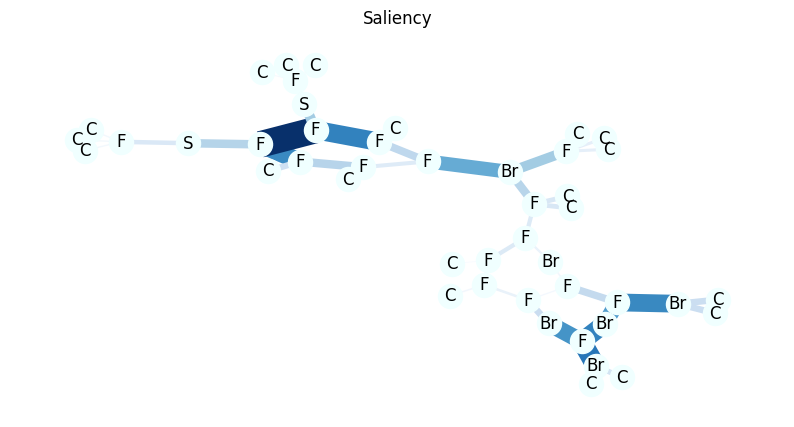

In [ ]:
import random
from collections import defaultdict

def aggregate_edge_directions(edge_mask, data):
    edge_mask_dict = defaultdict(float)
    for val, u, v in list(zip(edge_mask, *data.edge_index)):
        u, v = u.item(), v.item()
        if u > v:
            u, v = v, u
        edge_mask_dict[(u, v)] += val
    return edge_mask_dict


data = random.choice([t for t in test_dataset if not t.y.item()])
mol = to_molecule(data)

for title, method in [('Integrated Gradients', 'ig'), ('Saliency', 'saliency')]:
    edge_mask = explain(method, data, target=0)
    edge_mask_dict = aggregate_edge_directions(edge_mask, data)
    plt.figure(figsize=(10, 5))
    plt.title(title)
    draw_molecule(mol, edge_mask_dict)